# Predicting SBA Loan Defaults

Importing libraries used to perform this analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.linear_model import LogisticRegression
from sklearn import base
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

## Load dataset

This section loads the SBA dataset, and converts values into usable format

In [2]:
df = pd.read_csv('SBAnational.csv', parse_dates = [8, 19, 20])
df['GrAppv'] = df['GrAppv'].replace({'\$' : '', ',' : ''}, regex = True).astype(float)
df['SBA_Appv'] = df['SBA_Appv'].replace({'\$' : '', ',' : ''}, regex = True).astype(float)
df['ChgOffPrinGr'] = df['ChgOffPrinGr'].replace({'\$' : '', ',' : ''}, regex = True).astype(float)
df['DisbursementGross'] = df['DisbursementGross'].replace({'\$' : '', ',' : ''}, regex = True).astype(float)
df['BalanceGross'] = df['BalanceGross'].replace({'\$' : '', ',' : ''}, regex = True).astype(float)

df.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997-02-28,1997,...,N,Y,NaT,1999-02-28,60000.0,0.0,P I F,0.0,60000.0,48000.0
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,1997-02-28,1997,...,N,Y,NaT,1997-05-31,40000.0,0.0,P I F,0.0,40000.0,32000.0
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,1997-02-28,1997,...,N,N,NaT,1997-12-31,287000.0,0.0,P I F,0.0,287000.0,215250.0
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,1997-02-28,1997,...,N,Y,NaT,1997-06-30,35000.0,0.0,P I F,0.0,35000.0,28000.0
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,1997-02-28,1997,...,N,N,NaT,1997-05-14,229000.0,0.0,P I F,0.0,229000.0,229000.0


### List of Columns and Data Types in Dataset

In [3]:
df.dtypes

LoanNr_ChkDgt                 int64
Name                         object
City                         object
State                        object
Zip                           int64
Bank                         object
BankState                    object
NAICS                         int64
ApprovalDate         datetime64[ns]
ApprovalFY                   object
Term                          int64
NoEmp                         int64
NewExist                    float64
CreateJob                     int64
RetainedJob                   int64
FranchiseCode                 int64
UrbanRural                    int64
RevLineCr                    object
LowDoc                       object
ChgOffDate           datetime64[ns]
DisbursementDate     datetime64[ns]
DisbursementGross           float64
BalanceGross                float64
MIS_Status                   object
ChgOffPrinGr                float64
GrAppv                      float64
SBA_Appv                    float64
dtype: object

## Calculated Features

Additional features are calculated with the goal of making additional analysis. Some of these features include:
- Total Jobs: adds the jobs created and jobs retained to normalize the jobs in cases new jobs were created or existing jobs were retained. 
- Time to default: to calculate how long it took for a loan to be defaulted to visualize the distribution.
- Industry: extract the industry code from the NAICS code for classification purposes.
- Franchise: determine if a business is a franchise or not for classification purposes. 

In [4]:
df['TotalJobs'] = df['CreateJob'] + df['RetainedJob']
df['TimeDefault'] = df['ChgOffDate'] - df['DisbursementDate']

In [5]:
df['TimeDefault']

0              NaT
1              NaT
2              NaT
3              NaT
4              NaT
            ...   
899159         NaT
899160         NaT
899161         NaT
899162   1073 days
899163         NaT
Name: TimeDefault, Length: 899164, dtype: timedelta64[ns]

In [6]:
df['Industry'] = df.NAICS.astype(str).str.slice(0, 2)

In [7]:
def franchise(row):
    if row == 0 or row == 1:
        return False
    else: 
        return True

In [8]:
df['Franchise'] = df['FranchiseCode'].apply(franchise)

In [9]:
df['State'].fillna(0)

0         IN
1         IN
2         IN
3         OK
4         FL
          ..
899159    OH
899160    OH
899161    CA
899162    HI
899163    HI
Name: State, Length: 899164, dtype: object

In [10]:
def amount_cat (row):
    if row < 500000:
        return 1
    elif row < 1000000:
        return 2
    elif row < 1500000:
        return 3
    elif row < 2000000:
        return 4
    else: 
        return 5

In [11]:
df['z'] = df['GrAppv'].apply(amount_cat)

In [12]:
df['LoanDefaulted'] = df.ChgOffDate.notnull()
df

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,TotalJobs,TimeDefault,Industry,Franchise,z,LoanDefaulted
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997-02-28,1997,...,P I F,0.0,60000.0,48000.0,0,NaT,45,False,1,False
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,1997-02-28,1997,...,P I F,0.0,40000.0,32000.0,0,NaT,72,False,1,False
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,1997-02-28,1997,...,P I F,0.0,287000.0,215250.0,0,NaT,62,False,1,False
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,1997-02-28,1997,...,P I F,0.0,35000.0,28000.0,0,NaT,0,False,1,False
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,1997-02-28,1997,...,P I F,0.0,229000.0,229000.0,14,NaT,0,False,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,1997-02-27,1997,...,P I F,0.0,70000.0,56000.0,0,NaT,45,False,1,False
899160,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,1997-02-27,1997,...,P I F,0.0,85000.0,42500.0,0,NaT,45,False,1,False
899161,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,1997-02-27,1997,...,P I F,0.0,300000.0,225000.0,0,NaT,33,False,1,False
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,0,1997-02-27,1997,...,CHGOFF,46383.0,75000.0,60000.0,0,1073 days,0,False,1,True


In [13]:
df['NewExist'] = df['NewExist'].fillna(0)

## Statistics around Defaults

This section contains some general statistics around defaulted loans for exploratory purposes:
- Count
- Mean 
- Standard Deviation
- Min Value
- Max Value
- 25% Percentile
- 50% Percentile
- 75% Percentile

### Loan Amount

In [14]:
df['GrAppv'].describe()

count    8.991640e+05
mean     1.926870e+05
std      2.832634e+05
min      2.000000e+02
25%      3.500000e+04
50%      9.000000e+04
75%      2.250000e+05
max      5.472000e+06
Name: GrAppv, dtype: float64

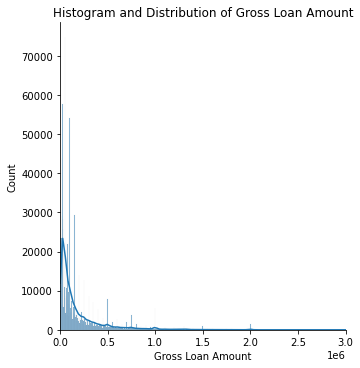

In [15]:
loan_hist = sns.displot(df['GrAppv'], kde = True)
loan_hist.set(xlim=(0, 3e06), xlabel = 'Gross Loan Amount', title = 'Histogram and Distribution of Gross Loan Amount')
# loan_hist.set_xlabel('Gross Loan Amount')
# loan_hist.set_title('Histogram and Distribution of Gross Loan Amount')
loan_hist

The Distribution of the loan amounts is right skewed; where smaller loans are more prevalent. 

### Total Jobs

In [16]:
df['TotalJobs'].describe()

count    899164.000000
mean         19.227634
std         473.091942
min           0.000000
25%           0.000000
50%           2.000000
75%           6.000000
max       17600.000000
Name: TotalJobs, dtype: float64

### Time to Default

In [17]:
df['TimeDefault'].describe()

count                          162289
mean     1575 days 11:20:04.007664560
std       942 days 19:34:59.961704480
min             -29661 days +00:00:00
25%                 961 days 00:00:00
50%                1414 days 00:00:00
75%                2003 days 00:00:00
max               11952 days 00:00:00
Name: TimeDefault, dtype: object

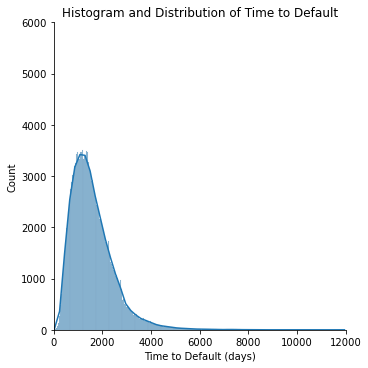

In [18]:
default_hist = sns.displot(df[df.TimeDefault.notnull()]['TimeDefault'].dt.days, kde = True)
default_hist.set(ylim=(0, 6000), xlim=(0, 12000), xlabel = 'Time to Default (days)', title = 'Histogram and Distribution of Time to Default')
# loan_hist.set_xlabel('Gross Loan Amount')
# loan_hist.set_title('Histogram and Distribution of Gross Loan Amount')
default_hist

Time to default is slightly right-skewed. 

### Percentage Charge-off

In [19]:
chgoff_percent = df['ChgOffPrinGr'].loc[df['LoanDefaulted'] == True] / df['GrAppv'] * 100
chgoff_percent.describe()

count    162699.000000
mean         73.245413
std          26.490728
min           0.000000
25%          56.912250
50%          81.325900
75%          95.704000
max         897.920000
dtype: float64

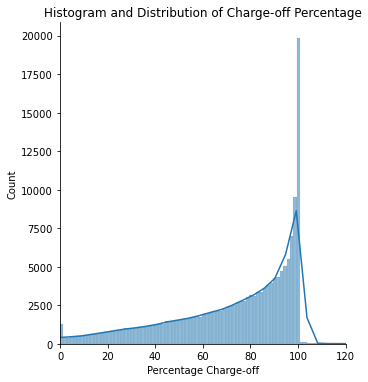

In [20]:
chgoff_hist = sns.displot(x = chgoff_percent, kde = True)
chgoff_hist.set(xlim = (0, 120), xlabel = 'Percentage Charge-off', title = 'Histogram and Distribution of Charge-off Percentage')
chgoff_hist

The distribution of charge-off percentage for defaulted loans is left-skewed; with a mean lower than the median. 

## Visualizations

### Total Jobs vs Loan Amount

This section explores if the loan amount influences the jobs created. To exclude outliers, considering the distribution, only jobs in the bottom 95% were considered. 

In [21]:
df.TotalJobs.quantile(0.95)

27.0

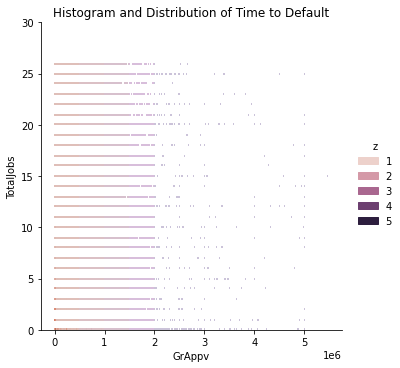

In [22]:
df_no_outliers = df.loc[df['TotalJobs'] < 27]
multi_hist = sns.displot(data=df_no_outliers, x=df_no_outliers['GrAppv'], y=df_no_outliers['TotalJobs'], hue = df_no_outliers['z'])
multi_hist.set(ylim=(0, 30), title = 'Histogram and Distribution of Time to Default')
multi_hist

The loan amount does not seem to influence the number of jobs created/retained. Therefore it may make more sense to issue many small loans as opposed to few large loans. 

### Loans issued by State

This section explores the total loan amounts by state

In [23]:
df1 = df.groupby('State').agg({'GrAppv': sum})

In [24]:
states = gpd.read_file('cb_2018_us_state_500k.shp')
states.rename(columns = {'STUSPS':'State'}, inplace = True)

In [25]:
states_map_loans = states.merge(df1, on = 'State')

In [26]:
states_map_loans.sort_values('GrAppv', axis=0, ascending=True)

,STATEFP,STATENS,AFFGEOID,GEOID,State,NAME,LSAD,ALAND,AWATER,geometry,GrAppv
35,11,01702382,0400000US11,11,DC,District of Columbia,00,158340391,18687198,"POLYGON ((-77.11976 38.93434, -77.11253 38.940...",2.462230e+08
40,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"MULTIPOLYGON (((-75.56555 39.51485, -75.56174 ...",3.186187e+08
39,15,01779782,0400000US15,15,HI,Hawaii,00,16633990195,11777809026,"MULTIPOLYGON (((-156.06076 19.73055, -156.0566...",4.451825e+08
23,56,01779807,0400000US56,56,WY,Wyoming,00,251458544898,1867670745,"POLYGON ((-111.05456 45.00095, -111.04507 45.0...",4.940757e+08
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169...",4.959768e+08
26,02,01785533,0400000US02,02,AK,Alaska,00,1478839695958,245481577452,"MULTIPOLYGON (((179.48246 51.98283, 179.48656 ...",5.111215e+08
13,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,"POLYGON ((-104.05788 44.99761, -104.05078 44.9...",7.124238e+08
29,50,01779802,0400000US50,50,VT,Vermont,00,23874175944,1030416650,"POLYGON ((-73.43774 44.04501, -73.43199 44.063...",7.924957e+08
38,23,01779787,0400000US23,23,ME,Maine,00,79887426037,11746549764,"MULTIPOLYGON (((-67.35580 44.64226, -67.35437 ...",8.399876e+08
46,38,01779797,0400000US38,38,ND,North Dakota,00,178707534813,4403267548,"POLYGON ((-104.04868 48.86378, -104.04865 48.8...",8.802879e+08


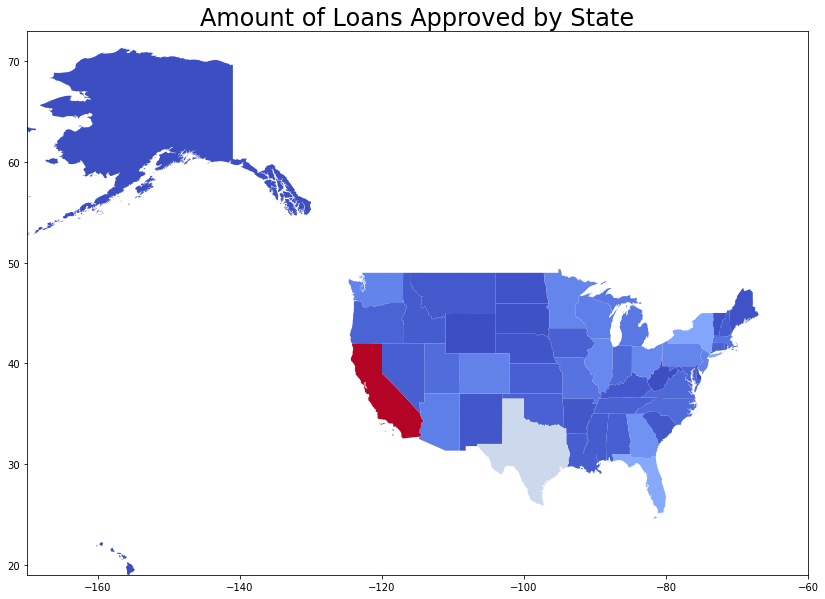

In [27]:
states_map_loans.plot('GrAppv', figsize = (25, 10), cmap = 'coolwarm')
plt.title('Amount of Loans Approved by State', fontsize=24)
plt.xlim(-170, -60)
plt.ylim(19, 73)
plt.show()

- Businesses in California by far receive more loans. 
- Larger states (population wise) receive more loans than smaller states. There is a good correlation between state population and loans issued to businesses in that state. 

## Model

Classification models are being fit to determine if accurate predictions can be made. 

The below code is used to select columns for the dataframe to generate feature matrix. 

In [28]:
class ColumnSelector(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        return X[self.col_names]

The below code generates test/train split of the dataset

In [29]:
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(df, df['LoanDefaulted'])

In [30]:
df.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv',
       'TotalJobs', 'TimeDefault', 'Industry', 'Franchise', 'z',
       'LoanDefaulted'],
      dtype='object')

Generation of feature matrix for categorical features. 

In [31]:
cat_features = Pipeline([
('ColumnSelector', ColumnSelector(['NewExist', 'UrbanRural', 'Franchise', 'Industry'])),
 ('OneHotEncoding', OneHotEncoder()),
 #('Classifier', RandomForestClassifier())
 ])

Generation of feature matrix for quantitative features. 

In [32]:
quant_features = Pipeline([
('ColumnSelector', ColumnSelector(['TotalJobs', 'GrAppv', 'SBA_Appv'])),
 # ('Classifier', RandomForestClassifier())
 ])

The below cells are used to combine the two feature matrices into a single matrix to be fed to our models. 

In [33]:

class EstimatorTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator
        # What needs to be done here?
    
    def fit(self, X, y):
        # Fit the stored estimator.
        self.estimator.fit(X, y)
        # Question: what should be returned?
        return self
    
    def transform(self, X):
        # Use predict on the stored estimator as a "transformation".
        # Be sure to return a 2-D array.
        arr = self.estimator.predict(X)
        arr_2d = np.reshape(arr, (-1, 1))
        return arr_2d

In [34]:
from sklearn.pipeline import FeatureUnion

union = FeatureUnion([
        # FeatureUnions use the same syntax as Pipelines
        ('CatFeatures', cat_features),
        ('QuantFeatures', quant_features)
    ])

### Logistic Regression Model

Attempting to fit a regular logistic regression model (for simplicity purposes):

In [35]:
model_logreg = Pipeline([
                    ('Union', union),
                    ('Classifier', LogisticRegression())
])

In [36]:
model_logreg.fit(X_log_train, y_log_train)
y_pred = model_logreg.predict(X_log_test)

In [37]:
model_logreg.score(X_log_train, y_log_train)

0.818899926301913

In [38]:
tn, fp, fn, tp = confusion_matrix(y_log_test, y_pred).ravel()
(tn, fp, fn, tp)

(184177, 33, 40555, 26)

In [39]:
percent_defaulted = df['LoanDefaulted'].loc[df['LoanDefaulted'] == True].count() / df['LoanDefaulted'].count() *100
percent_defaulted

18.09447442290839

In this case the model is not doing much better than predicting the majority class in many cases. 
It can be seen in the confusion matrix in the high number of false negatives, and low number of true positives. 

### Random Forest Model

A random forest model was fit to try to make better predictions than a logistic regression. 

In [40]:
model = Pipeline([
                    ('Union', union),
                    ('Classifier', RandomForestClassifier())
])

In [41]:
model.fit(X_log_train, y_log_train)
y_pred = model.predict(X_log_test)

In [42]:
model.score(X_log_train, y_log_train)

0.8802176243710824

In [43]:
tn, fp, fn, tp = confusion_matrix(y_log_test, y_pred).ravel()
(tn, fp, fn, tp)

(174298, 9912, 33316, 7265)

In this case the accuracy of the predictions improved as observed by the model score, as well as the confusion matrix. While the predictions are better than the ones accomplished by standard logistic regression, the features analyzed are not great at making predictions on loan defaults. Additional features may need to be considered in order to make more accurate predictions. 